<a href="https://colab.research.google.com/github/deinal/gcn-transition-matrix/blob/main/gcn_regression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# GCN Regression on a Directed Graph

In [2]:
import torch
import torch.nn.functional as F
from torch_geometric.nn import GCNConv, global_mean_pool, GraphNorm
from torch_geometric.data import Data, DataLoader

import numpy as np
import networkx as nx
import matplotlib.pyplot as plt

## Create dataloader

In [3]:
Nnodes = 5
num_node_features = 10
num_graphs = 300

graphs = []

for _ in range(num_graphs):
    edge_indices = np.zeros((2, Nnodes * Nnodes), dtype=np.int64)
    edge_weights = np.zeros(Nnodes * Nnodes, dtype=np.float32)

    # Generating node features
    x = np.random.rand(Nnodes, num_node_features)

    # Factor to relate node features to the target
    target_factor = np.random.rand(num_node_features)

    ii = 0
    for i in range(Nnodes):
        for j in range(Nnodes):
            edge_indices[:, ii] = np.array([i, j])

            # Generating edge weights based on node features and the target factor
            edge_weights[ii] = int(abs(np.sum((x[i] - x[j]) * target_factor)) * 10)
            ii += 1

    edge_index = torch.tensor(edge_indices, dtype=torch.long)
    edge_weight = torch.tensor(edge_weights, dtype=torch.float)
    x = torch.tensor(x, dtype=torch.float)  # Converting node features to tensor

    # Setting target as the mean of the target factor
    y = torch.tensor([np.mean(target_factor)], dtype=torch.float).view(1, -1)

    data = Data(x=x, edge_index=edge_index, edge_attr=edge_weight, y=y)
    graphs.append(data)

dataset = graphs

## Plot directed graph with edge weights

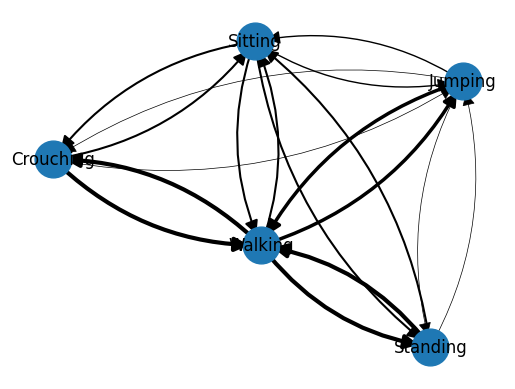

In [4]:
# Extract the first graph
graph = dataset[0]
transition_matrix = graph.edge_attr.view(Nnodes, Nnodes).numpy()

G = nx.DiGraph()

actions = ["Sitting", "Standing", "Walking", "Crouching", "Jumping"]
for i in range(Nnodes):
    G.add_node(i, action=actions[i])

for i in range(Nnodes):
    for j in range(Nnodes):
        if transition_matrix[i, j] > 0:
            G.add_edge(i, j, weight=transition_matrix[i, j])

# Draw the graph
pos = nx.spring_layout(G)
edge_labels = {(u, v): f'{d["weight"]:.2f}' for u, v, d in G.edges(data=True)}

fig, ax = plt.subplots()
nx.draw_networkx_nodes(G, pos, ax=ax, node_size=700)
edges = nx.draw_networkx_edges(G, pos, ax=ax, connectionstyle='arc3,rad=0.2', edge_color='black', width=[d['weight']*0.5 for u, v, d in G.edges(data=True)], arrows=True, arrowsize=20)
nx.draw_networkx_labels(G, pos, ax=ax, labels={i: G.nodes[i]['action'] for i in G.nodes})
# nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, ax=ax)

plt.axis('off')
plt.show()

## Define model

Relevant papers

- Graph Convolutional Networks https://arxiv.org/abs/1609.02907
- Residual connection https://arxiv.org/abs/1512.03385
- Dropout https://jmlr.org/papers/v15/srivastava14a.html
- GraphNorm https://arxiv.org/abs/2009.03294
- GELU https://arxiv.org/abs/1606.08415

In [11]:
class SimpleGCN(torch.nn.Module):
    def __init__(self, num_node_features):
        super(SimpleGCN, self).__init__()
        self.conv1 = GCNConv(num_node_features, 64)
        self.norm1 = GraphNorm(64)
        self.conv2 = GCNConv(64, 32)
        self.norm2 = GraphNorm(32)
        self.fc = torch.nn.Linear(32, 1)

    def forward(self, data):
        x, edge_index, edge_weight, batch = data.x, data.edge_index, data.edge_attr, data.batch

        # First GCN layer
        x = F.gelu(self.norm1(self.conv1(x, edge_index, edge_weight)))
        x = F.dropout(x, p=0.0, training=self.training)

        # Second GCN layer
        x = F.gelu(self.norm2(self.conv2(x, edge_index, edge_weight)))
        x = global_mean_pool(x, batch)

        # Fully connected layer
        x = self.fc(x)

        return x

In [12]:
class GCN(torch.nn.Module):
    def __init__(self, num_node_features):
        super(GCN, self).__init__()
        self.conv1 = GCNConv(num_node_features, 64)
        self.norm1 = GraphNorm(64)
        self.conv2 = GCNConv(64, 32)
        self.norm2 = GraphNorm(32)
        self.conv3 = GCNConv(32, 16)
        self.norm3 = GraphNorm(16)
        self.fc = torch.nn.Linear(16, 1)

        # Linear transformations for skip connections
        self.skip1 = torch.nn.Linear(num_node_features, 64)
        self.skip2 = torch.nn.Linear(64, 32)
        self.skip3 = torch.nn.Linear(32, 16)

    def forward(self, data):
        x, edge_index, edge_weight, batch = data.x, data.edge_index, data.edge_attr, data.batch

        # First GCN layer with skip connection
        x1 = F.gelu(self.norm1(self.conv1(x, edge_index, edge_weight)))
        x1 += self.skip1(x)
        x1 = F.dropout(x1, p=0.0, training=self.training)

        # Second GCN layer with skip connection
        x2 = F.gelu(self.norm2(self.conv2(x1, edge_index, edge_weight)))
        x2 += self.skip2(x1)
        x2 = F.dropout(x2, p=0.0, training=self.training)

        # Third GCN layer with skip connection
        x3 = F.gelu(self.norm3(self.conv3(x2, edge_index, edge_weight)))
        x3 += self.skip3(x2)
        x3 = global_mean_pool(x3, batch)

        # Fully connected layer
        x = self.fc(x3)

        return x

## Train

In [13]:
def train_and_evaluate(model, train_loader, val_loader, optimizer, loss_fn, epochs=10):
    train_losses = []
    val_losses = []

    for epoch in range(epochs):
        model.train()
        total_loss = 0
        for data in train_loader:
            optimizer.zero_grad()
            output = model(data)
            loss = loss_fn(output, data.y)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        avg_loss = total_loss / len(train_loader)
        train_losses.append(avg_loss)

        model.eval()
        val_loss = 0
        with torch.no_grad():
            for data in val_loader:
                output = model(data)
                loss = loss_fn(output, data.y)
                val_loss += loss.item()
        avg_val_loss = val_loss / len(val_loader)
        val_losses.append(avg_val_loss)

        print(f'Epoch {epoch+1}/{epochs}, Loss: {avg_loss:.4f}, Validation Loss: {avg_val_loss:.4f}')

    return train_losses, val_losses

In [14]:
# Initialize models, loss functions, and optimizers
gcn_model = GCN(num_node_features)
simple_gcn_model = SimpleGCN(num_node_features)

optimizer_gcn = torch.optim.Adam(gcn_model.parameters(), lr=1e-4)
optimizer_simple_gcn = torch.optim.Adam(simple_gcn_model.parameters(), lr=1e-4)

loss_fn = torch.nn.MSELoss()

# Split the dataset into training and validation sets
train_dataset = dataset[:80]
val_dataset = dataset[80:]

train_loader = DataLoader(train_dataset, batch_size=1, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=1, shuffle=False)

# Train and evaluate SimpleGCN
print("Training SimpleGCN...")
simple_gcn_train_losses, simple_gcn_val_losses = train_and_evaluate(simple_gcn_model, train_loader, val_loader, optimizer_simple_gcn, loss_fn)

# Train and evaluate GCN
print("Training GCN...")
gcn_train_losses, gcn_val_losses = train_and_evaluate(gcn_model, train_loader, val_loader, optimizer_gcn, loss_fn)


Training SimpleGCN...
Epoch 1/10, Loss: 0.3076, Validation Loss: 0.2565
Epoch 2/10, Loss: 0.1947, Validation Loss: 0.1595
Epoch 3/10, Loss: 0.1142, Validation Loss: 0.0925
Epoch 4/10, Loss: 0.0623, Validation Loss: 0.0501
Epoch 5/10, Loss: 0.0325, Validation Loss: 0.0280
Epoch 6/10, Loss: 0.0183, Validation Loss: 0.0173
Epoch 7/10, Loss: 0.0125, Validation Loss: 0.0130
Epoch 8/10, Loss: 0.0104, Validation Loss: 0.0115
Epoch 9/10, Loss: 0.0093, Validation Loss: 0.0109
Epoch 10/10, Loss: 0.0088, Validation Loss: 0.0110
Training GCN...
Epoch 1/10, Loss: 0.1038, Validation Loss: 0.0150
Epoch 2/10, Loss: 0.0101, Validation Loss: 0.0095
Epoch 3/10, Loss: 0.0094, Validation Loss: 0.0096
Epoch 4/10, Loss: 0.0092, Validation Loss: 0.0095
Epoch 5/10, Loss: 0.0090, Validation Loss: 0.0096
Epoch 6/10, Loss: 0.0085, Validation Loss: 0.0096
Epoch 7/10, Loss: 0.0086, Validation Loss: 0.0098
Epoch 8/10, Loss: 0.0084, Validation Loss: 0.0100
Epoch 9/10, Loss: 0.0082, Validation Loss: 0.0100
Epoch 10/1

## Plot loss

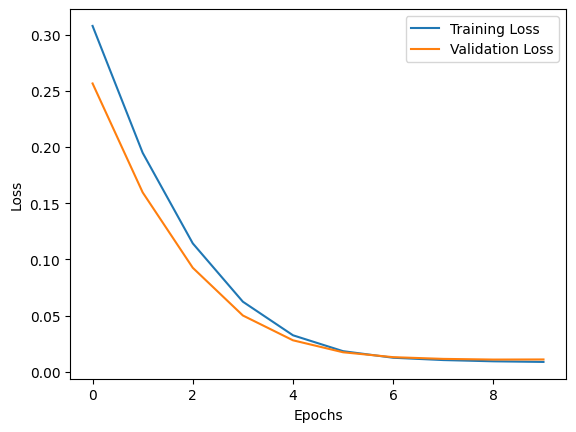

In [15]:
plt.plot(simple_gcn_train_losses, label='Training Loss')
plt.plot(simple_gcn_val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

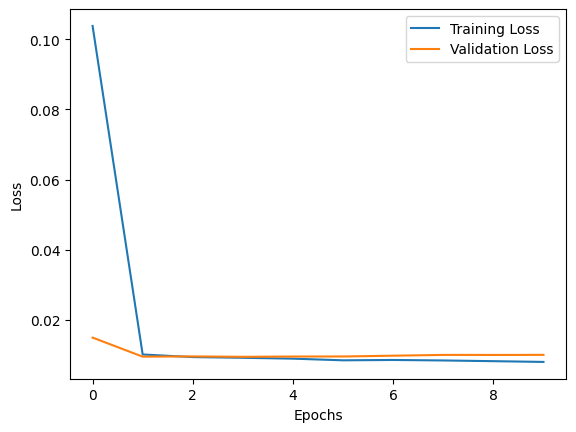

In [16]:
plt.plot(gcn_train_losses, label='Training Loss')
plt.plot(gcn_val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()